In [1]:
code_dir = '../../../reference-matching-evaluation/'
data_dir = 'data/'
img_dir = 'images/'
styles = ['american-chemical-society', 'american-institute-of-physics', 'american-institute-of-physics-noise', 'apa',
          'apa-noise', 'chicago-author-date', 'degraded_all_authors', 'degraded_one_author',
          'degraded_title_scrambled', 'elsevier-without-titles', 'modern-language-association']

In [2]:
import sys
sys.path.append(code_dir)

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import utils.data_format_keys as dfk

from evaluation.document_metrics import ByDocumentMetricsResults
from evaluation.split_metrics import SplitByRefAttrResults
from scipy.stats import ttest_rel
from utils.utils import read_json

In [3]:
def read_data(algorithm):
    dataset = []
    for style in styles:
        d = read_json(data_dir + 'matched/matched-' + algorithm + '-' + style + '.json')
        dois = d[dfk.DATASET_DOIS]
        dataset.extend(d[dfk.DATASET_DATASET])
    return dataset, dois

def print_summary(results, name):
    for av, ci, metric in results.metrics_groups:
        print('Average {} for {} algorithm: {:.4f} (confidence interval (95%): {:.4f} - {:.4f})'
              .format(metric, name, results.get(av), results.get(ci)[0], results.get(ci)[1]))

In [4]:
dataset_stq, _ = read_data('stq')
len(dataset_stq)/11

7374.0

In [5]:
dataset_stq, dois = read_data('stq')
results_stq = ByDocumentMetricsResults(dataset_stq, dois)
results_style_stq = SplitByRefAttrResults(dataset_stq, 'style', dois)
print_summary(results_stq, 'STQ')

Average precision for STQ algorithm: 0.9933 (confidence interval (95%): 0.9910 - 0.9956)
Average recall for STQ algorithm: 0.4203 (confidence interval (95%): 0.4095 - 0.4312)
Average F1 for STQ algorithm: 0.5289 (confidence interval (95%): 0.5164 - 0.5413)


In [6]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_valid_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

In [7]:
dataset_sbm, _ = read_data('sbm')
dataset_sbm = modify_simple_threshold(dataset_sbm, 53)
results_sbm_53 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_53 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_53, 'SBM (t=53)')

Average precision for SBM (t=53) algorithm: 0.9890 (confidence interval (95%): 0.9863 - 0.9917)
Average recall for SBM (t=53) algorithm: 0.7127 (confidence interval (95%): 0.7021 - 0.7233)
Average F1 for SBM (t=53) algorithm: 0.7866 (confidence interval (95%): 0.7763 - 0.7968)


In [8]:
dataset_sbm, _ = read_data('sbm')
dataset_sbm = modify_norm_threshold(dataset_sbm, 0.47)
results_sbm_047 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_047 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_047, 'SBM (tnorm=0.47)')

Average precision for SBM (tnorm=0.47) algorithm: 0.9872 (confidence interval (95%): 0.9844 - 0.9901)
Average recall for SBM (tnorm=0.47) algorithm: 0.7905 (confidence interval (95%): 0.7796 - 0.8015)
Average F1 for SBM (tnorm=0.47) algorithm: 0.8354 (confidence interval (95%): 0.8249 - 0.8458)


In [9]:
dataset_sbmv, _ = read_data('sbmv')
dataset_sbmv = modify_simple_threshold(dataset_sbmv, 0.6)
results_sbmv_06 = ByDocumentMetricsResults(dataset_sbmv, dois)
results_style_sbmv_06 = SplitByRefAttrResults(dataset_sbmv, 'style', dois)
print_summary(results_sbmv_06, 'SBMV (tvalid=0.6)')

Average precision for SBMV (tvalid=0.6) algorithm: 0.9923 (confidence interval (95%): 0.9902 - 0.9945)
Average recall for SBMV (tvalid=0.6) algorithm: 0.7902 (confidence interval (95%): 0.7802 - 0.8002)
Average F1 for SBMV (tvalid=0.6) algorithm: 0.8448 (confidence interval (95%): 0.8352 - 0.8544)


In [10]:
def get_means(results):
    return [results.get(m) for m in [dfk.EVAL_MEAN_PREC, dfk.EVAL_MEAN_REC, dfk.EVAL_MEAN_F1]]

def get_ses(results):
    return [(results.get(m)[1]-results.get(m)[0])/2 for m in [dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC, dfk.EVAL_CI_F1]]

def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 15})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

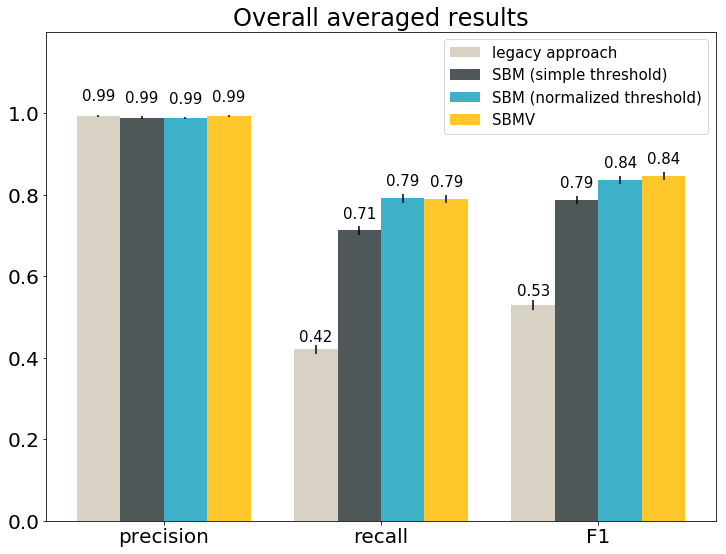

In [11]:
ind = np.arange(3)
width = 0.2
plt.rcParams.update({'font.size': 20, 'legend.fontsize': 15}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - width, get_means(results_stq), width, color='#d8d2c4', yerr=get_ses(results_stq))
rects2 = ax.bar(ind, get_means(results_sbm_53), width, color='#4f5858', yerr=get_ses(results_sbm_53))
rects3 = ax.bar(ind + width, get_means(results_sbm_047), width, color='#3eb1c8', yerr=get_ses(results_sbm_047))
rects4 = ax.bar(ind + 2*width, get_means(results_sbmv_06), width, color='#ffc72c', yerr=get_ses(results_sbmv_06))

ax.set_ylabel('')
ax.set_title('Overall averaged results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
          ('legacy approach', 'SBM (simple threshold)', 'SBM (normalized threshold)', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)

plt.savefig(img_dir + 'overall.png', dpi=300, bbox_inches='tight')

In [12]:
results_docs_stq = results_stq.get(dfk.EVAL_DOC_METRICS)
results_docs_sbmv = results_sbmv_06.get(dfk.EVAL_DOC_METRICS)
_, p = ttest_rel(results_docs_stq['precision'], results_docs_sbmv['precision'])
c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
print('precision p-value: {:.4f} ({})'.format(p, c))

precision p-value: 0.4401 (this is not statistically significant)


In [13]:
results_docs_sbm = results_sbm_047.get(dfk.EVAL_DOC_METRICS)
results_docs_sbmv = results_sbmv_06.get(dfk.EVAL_DOC_METRICS)
_, p = ttest_rel(results_docs_sbm['recall'], results_docs_sbmv['recall'])
c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
print('recall p-value: {:.4f} ({})'.format(p, c))

recall p-value: 0.9281 (this is not statistically significant)


In [14]:
results_docs_sbm = results_sbm_047.get(dfk.EVAL_DOC_METRICS)
results_docs_sbmv = results_sbmv_06.get(dfk.EVAL_DOC_METRICS)
_, p = ttest_rel(results_docs_sbm['F1'], results_docs_sbmv['F1'])
c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
print('F1 p-value: {:.4f} ({})'.format(p, c))

F1 p-value: 0.0108 (this is statistically significant)


In [15]:
results_docs_stq = results_stq.get(dfk.EVAL_DOC_METRICS)
results_docs_sbmv = results_sbmv_06.get(dfk.EVAL_DOC_METRICS)
_, p = ttest_rel(results_docs_stq['F1'], results_docs_sbmv['F1'])
c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
print('F1 p-value: {:.4f} ({})'.format(p, c))

F1 p-value: 0.0000 (this is statistically significant)


In [16]:
results_docs_stq = results_stq.get(dfk.EVAL_DOC_METRICS)
results_docs_sbm = results_sbm_047.get(dfk.EVAL_DOC_METRICS)
_, p = ttest_rel(results_docs_stq['F1'], results_docs_sbm['F1'])
c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
print('F1 p-value: {:.4f} ({})'.format(p, c))

F1 p-value: 0.0000 (this is statistically significant)


In [17]:
results_docs_stq = results_stq.get(dfk.EVAL_DOC_METRICS)
results_docs_sbm = results_sbm_53.get(dfk.EVAL_DOC_METRICS)
_, p = ttest_rel(results_docs_stq['F1'], results_docs_sbm['F1'])
c = 'this is statistically significant' if p < 0.05 else 'this is not statistically significant'
print('F1 p-value: {:.4f} ({})'.format(p, c))

F1 p-value: 0.0000 (this is statistically significant)


In [18]:
def get_results_style(results, style):
    results = results.get(dfk.EVAL_SPLIT_METRICS)
    results = results.iloc[:,[7,8,9]][results['style'] == style]
    return list(results.to_records(index=False)[0])

In [19]:
styles = [['apa-noise', 'american-institute-of-physics-noise'],
          ['apa', 'chicago-author-date', 'modern-language-association'],
          ['american-chemical-society', 'american-institute-of-physics', 'elsevier-without-titles'],
          ['degraded_all_authors', 'degraded_one_author', 'degraded_title_scrambled']]
titles = [['apa+noise', 'aip+noise'],
          ['apa', 'chicago', 'mla'],
          ['acs', 'aip', 'ewt'],
          ['degraded', 'one author', 'title scrambled']]

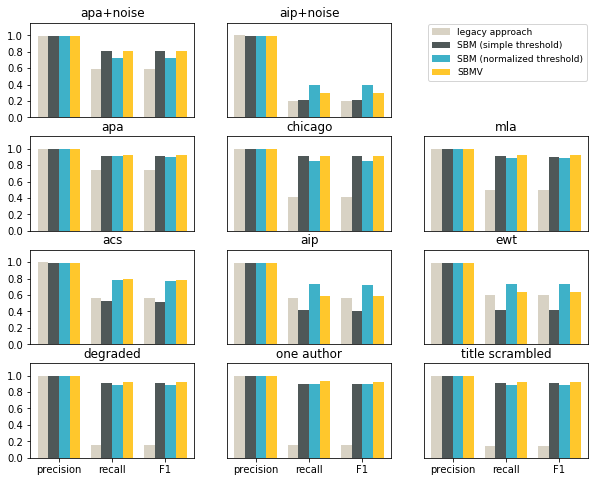

In [20]:
plt.rcParams.update({'font.size': 10, 'legend.fontsize': 9})
f, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 8))
ind = np.arange(3)
width = 0.2

for i in range(4):
    for j in range(3):
        if len(styles) <= i or len(styles[i]) <= j:
            continue
        rects1 = axes[i, j].bar(ind-width, get_results_style(results_style_stq, styles[i][j]), width, color='#d8d2c4')
        rects2 = axes[i, j].bar(ind, get_results_style(results_style_sbm_53, styles[i][j]), width, color='#4f5858')
        rects3 = axes[i, j].bar(ind+width, get_results_style(results_style_sbm_047, styles[i][j]), width, color='#3eb1c8')
        rects4 = axes[i, j].bar(ind+2*width, get_results_style(results_style_sbmv_06, styles[i][j]), width, color='#ffc72c')
        axes[i, j].set_title(titles[i][j])

axes[0, 0].set_xticks(ind + width / 2)
axes[0, 0].set_xticklabels(('precision', 'recall', 'F1'))
axes[0, 2].legend((rects1[0], rects2[0], rects3[0], rects4[0]),
                  ('legacy approach', 'SBM (simple threshold)', 'SBM (normalized threshold)', 'SBMV'),
                  loc=3, bbox_to_anchor=(0, 0.34))

for i in range(3):
    for j in range(3):
        axes[i, j].xaxis.set_ticks_position('none') 
for i in range(4):
    for j in [1,2]:
        axes[i, j].yaxis.set_ticks_position('none')
axes[0, 2].axis('off')

plt.ylim(0, 1.15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig(img_dir + 'by_style.png', dpi=300, bbox_inches='tight')